# Guess Core and use other methods to interpolate

In [1]:
import os, sys
import pickle
from scf_guess_tools import  Backend, load, calculate, guess
import numpy as np
import matplotlib.pyplot as plt
from BlockMatrix import BlockMatrix
from tensorflow.keras.callbacks import TensorBoard
import datetime


2025-05-22 16:13:59.948138: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 16:13:59.971168: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 16:14:00.074896: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 16:14:00.166906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747923240.230096   12937 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747923240.24

In [ ]:
with open('../c5h4n2o2/models/test_data.pkl', 'rb') as f:
    test = pickle.load(f)
with open('../c5h4n2o2/models/train_data.pkl', 'rb') as f:
    train = pickle.load(f) # fock, overlap, file, density
train_X = np.array([overlap for _, overlap, _, _ in train])
train_y = np.array([fock for fock, _, _, _ in train])
test_X = np.array([overlap for _, overlap, _, _ in test])
test_y = np.array([fock for fock, _, _, _ in test])
train_files = np.array([file for _, _, file, _ in train])
test_files = np.array([file for _, _, file, _ in test])
train_densities = np.array([density for _, _, _, density in train])
test_densities = np.array([density for _, _, _, density in test])
mat_dim = train_X[0].shape[0]
mat_dim


(49, 49)


ValueError: too many values to unpack (expected 4)

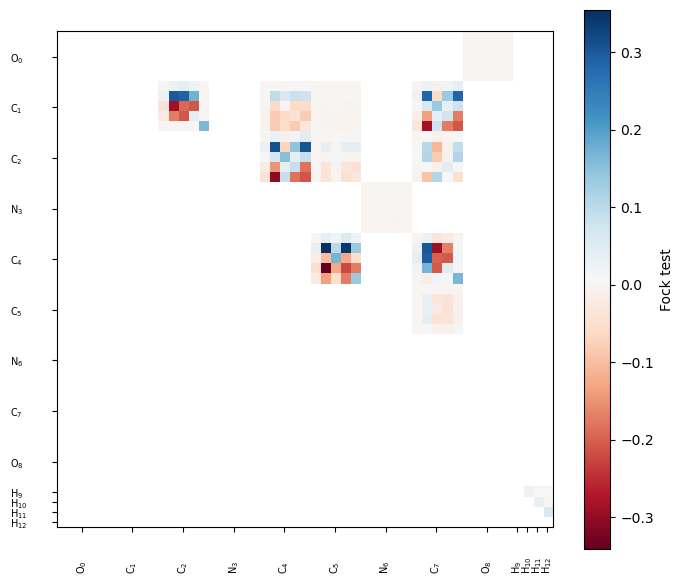

np.float64(49.0)

In [3]:
mol = load(train_files[10], Backend.PY).native
dm = BlockMatrix(mol, train_X[10]) # can also override the matrix
dm.plot_blocks_by_type("homo", labels="atoms", figsize=(8, 7), title="Fock test", imshow_args={"cmap": "RdBu"})
dm.Matrix.trace()

## 1) First Trial
Just learn the Fock center Block-matrix for the general Case for all given elements! 

In [4]:
elements = ["C", "N", "O", "H"]
training_centers_X = {"C":[], "N":[], "O":[], "H":[]}
training_centers_y = {"C":[], "N":[], "O":[], "H":[]}
test_centers_X = {"C":[], "N":[], "O":[], "H":[]}
test_centers_y = {"C":[], "N":[], "O":[], "H":[]}

for fock, overlap, file, _ in train:
    mol = load(file, Backend.PY).native
    dmX = BlockMatrix(mol, overlap)
    dmY = BlockMatrix(mol, fock)
    for element in elements:
        for block in dmX.get_blocks_by_atom(element, block_type="center"):
            training_centers_X[element].append(block)
        for block in dmY.get_blocks_by_atom(element, block_type="center"):
            training_centers_y[element].append(block)

for fock, overlap, file, _ in test:
    mol = load(file, Backend.PY).native
    dmX = BlockMatrix(mol, overlap)
    dmY = BlockMatrix(mol, fock)
    for element in elements:
        for block in dmX.get_blocks_by_atom(element, block_type="center"):
            test_centers_X[element].append(block)
        for block in dmY.get_blocks_by_atom(element, block_type="center"):
            test_centers_y[element].append(block)


True

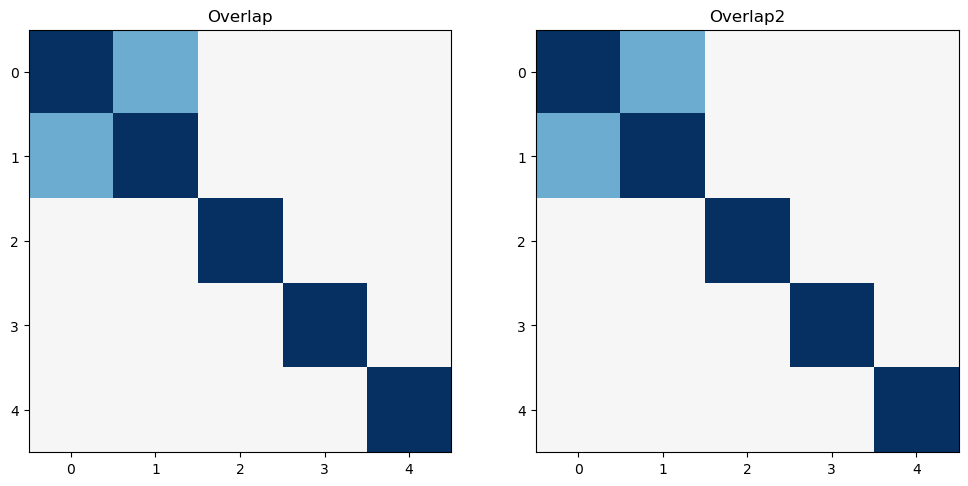

In [5]:
c_s = training_centers_X["C"]
for i in range(len(c_s)):
    diff = c_s[0] - c_s[i]
    if diff.sum() != 0: 
        print("Not equal")
# it seems that everything in sto-3g is actually the same
mol1 = load(train_files[0], Backend.PY).native
mol2 = load(train_files[1], Backend.PY).native
center1 = BlockMatrix(mol1)
center2 = BlockMatrix(mol2)
mean_c_ovlp1 = np.mean(center1.get_blocks_by_atom("C", block_type="center"), axis=0)
mean_c_ovlp2 = np.mean(center2.get_blocks_by_atom("C", block_type="center"), axis=0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(mean_c_ovlp1, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[0].set_title("Overlap")
ax[1].imshow(mean_c_ovlp2, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[1].set_title("Overlap2")
np.allclose(mean_c_ovlp1, mean_c_ovlp2)

In [6]:
# try different basis sets
ex_overlap, ex_fock, ex_density = [], [], []
mols = []
for i, file in enumerate(train_files[:5]):
    mol = load(file, Backend.PY)
    mols.append(mol)
    wf = calculate(mol, basis="6-31g", guess="minao", method="dft", functional="b3lypg")
    ex_overlap.append(wf.overlap())
    ex_fock.append(wf.fock())
    ex_density.append(wf.density())


converged SCF energy = -452.71289020753
converged SCF energy = -452.630906802164
converged SCF energy = -452.619631213145
converged SCF energy = -452.720086127981
converged SCF energy = -452.642850787729


False


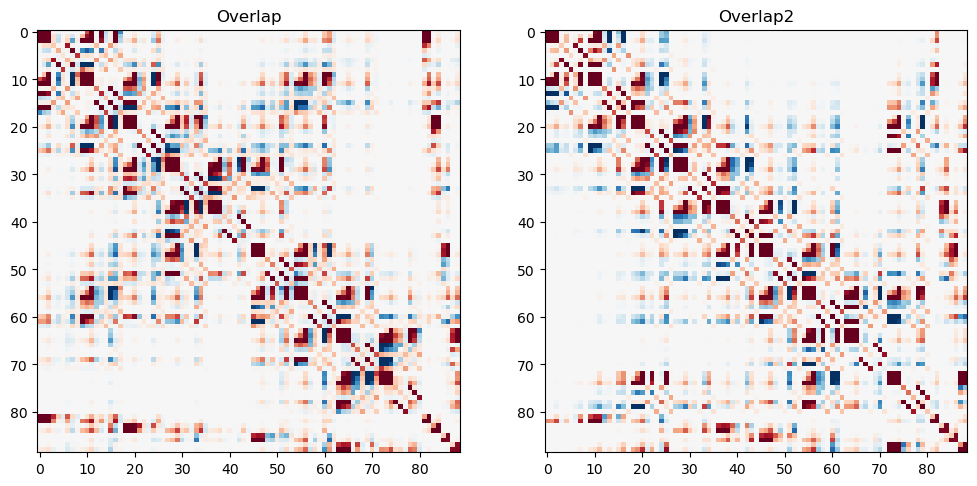

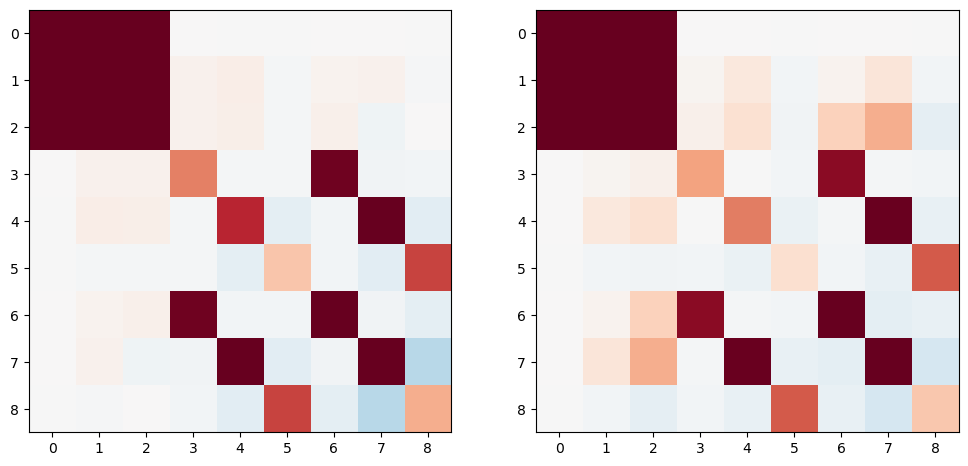

In [7]:
ex1, ex2 = 0,3
center1 = BlockMatrix(mols[ex1].native, ex_fock[ex1].numpy)
center2 = BlockMatrix(mols[ex2].native, ex_fock[ex2].numpy)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(center1.Matrix, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[0].set_title("Overlap")
ax[1].imshow(center2.Matrix, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[1].set_title("Overlap2")

# They are also the SAME!!! - makes sense because center block is basically coef. 
c_mean1 = np.mean(center1.get_blocks_by_atom("C", block_type="center"), axis=0)
c_mean2 = np.mean(center2.get_blocks_by_atom("C", block_type="center"), axis=0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(c_mean1, cmap="RdBu", vmin=-0.5, vmax=0.5)
# ax[0].set_title("Overlap mean")
# ax[1].imshow(c_mean2, cmap="RdBu", vmin=-0.5, vmax=0.5)
# ax[1].set_title("Overlap2 mean")
# np.allclose(c_mean1, c_mean2)
c1 = center1.get_blocks_by_atom("C", block_type="center")[0]
c2 = center1.get_blocks_by_atom("C", block_type="center")[2]
print(np.allclose(c1, c2))
ax[0].imshow(c1, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax[1].imshow(c2, cmap="RdBu", vmin=-0.5, vmax=0.5)

### 1a) Only learn the diagonal!

In [8]:
train_overlap_X = np.array([overlap for _, overlap, _, _ in train])
test_overlap_X = np.array([overlap for _, overlap, _, _ in test])
train_fock_diag = np.array([np.diag(fock) for fock, _, _, _ in train])
test_fock_diag = np.array([np.diag(fock) for fock, _, _, _ in test])
test_fock_full = np.array([fock for fock, _, _, _ in test])
test_density_full = np.array([density for _, _, _, density in test])

In [9]:
import tensorflow as tf
from tensorflow import keras
import pickle, os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
sys.path.append("..")
from utils import plot_mat_comp, flatten_triang, unflatten_triang, flatten_triang_batch, unflatten_triang_batch, perform_calculation, density_from_fock, reverse_mat_permutation, benchmark_cycles

In [10]:
train_overlap_X_flat = flatten_triang_batch(train_overlap_X)
test_overlap_X_flat = flatten_triang_batch(test_overlap_X)

# scalerX = StandardScaler()
# scalerY = StandardScaler()

train_overlap_X_flat.shape

(406, 1225)

In [11]:
train_fock_diag.shape

(406, 49)

In [41]:
tf.random.set_seed(42)
flattened_dim = train_overlap_X_flat.shape[1]
diag_dim = train_fock_diag.shape[1]
inputs = tf.keras.Input(shape=(flattened_dim,))
x = tf.keras.layers.Dense(512, activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(diag_dim)(x)

basic_model = tf.keras.Model(inputs=inputs, outputs=outputs)
basic_model.compile(optimizer='adam', loss="mae", metrics=["mse", 'mae'])

Epoch 1/250


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.9941 - mae: 2.9941 - mse: 32.0421 - val_loss: 2.6974 - val_mae: 2.6974 - val_mse: 31.5827
Epoch 2/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5184 - mae: 2.5184 - mse: 25.6204 - val_loss: 2.5554 - val_mae: 2.5554 - val_mse: 29.1996
Epoch 3/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.1742 - mae: 2.1742 - mse: 19.2586 - val_loss: 2.3798 - val_mae: 2.3798 - val_mse: 25.4797
Epoch 4/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7598 - mae: 1.7598 - mse: 12.0126 - val_loss: 2.0522 - val_mae: 2.0522 - val_mse: 19.0667
Epoch 5/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3279 - mae: 1.3279 - mse: 5.4493 - val_loss: 1.7347 - val_mae: 1.7347 - val_mse: 13.4943
Epoch 6/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1739 - mae: 1.1739 - mse: 3.5874 - val_loss: 1.6869 - val_mae: 1.6869 - val_mse: 12.7540
Epoch 7/250
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0399 - mae: 1.0399 - mse: 2.9060 - val_l

Text(0.5, 1.0, 'Model loss')

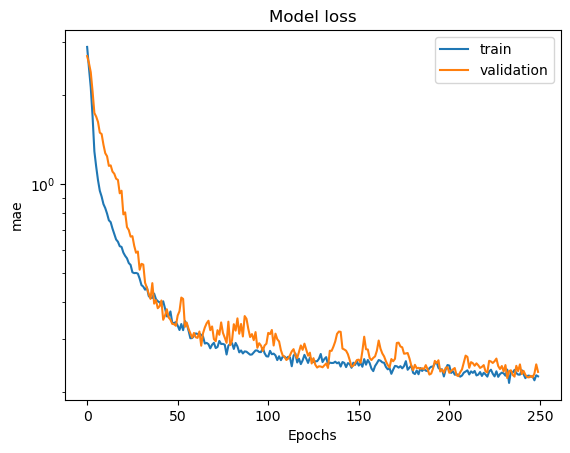

In [42]:
# Define a log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with TensorBoard callback
basic_history = basic_model.fit(
    train_overlap_X_flat, 
    train_fock_diag, 
    epochs=250, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1, 
    callbacks=[tensorboard_callback]
)

# Plot the training and validation loss
plt.plot(basic_history.history['loss'], label='train')
plt.plot(basic_history.history['val_loss'], label='validation')
plt.yscale('log')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Model loss')

In [53]:
# save models
os.makedirs("models", exist_ok=True)
if os.path.exists("models/basic_model.keras") and input("Overwrite existing model? (y/n)") == "y":
    os.remove("models/basic_model.keras")
    basic_model.save("models/basic_model.keras")
    print("Model saved")
else:
    basic_model.save("models/basic_model.keras")
    print("Model saved")


Model saved


In [12]:
# load model
basic_model = tf.keras.models.load_model("models/basic_model.keras")
print(basic_model.summary())

2025-04-22 09:10:54.606173: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 1225)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │       627,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 49)             │        12,593 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,318,997 (8.85 MB)

 Trainable params: 772,657 (2.95 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 1,545,316 (5.89 MB)

None


In [23]:
test_pred_fock_diag = basic_model.predict(test_overlap_X_flat)
test_pred_fock_diag.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


(102, 49)

In [14]:
def reconstruct_Fock(diag, ovlp, K = 1.75): 
    """Take diagonal and reconstruct the Fock matrix using GWH
    """
    mat_dim = diag.shape[0]
    out = np.zeros((mat_dim, mat_dim))
    for i in range(mat_dim):
        for j in range(mat_dim):
            if i == j:
                out[i, j] = diag[i]
            else:
                out[i, j] = K * ovlp[i, j] * (diag[i] + diag[j]) / 2
    return out

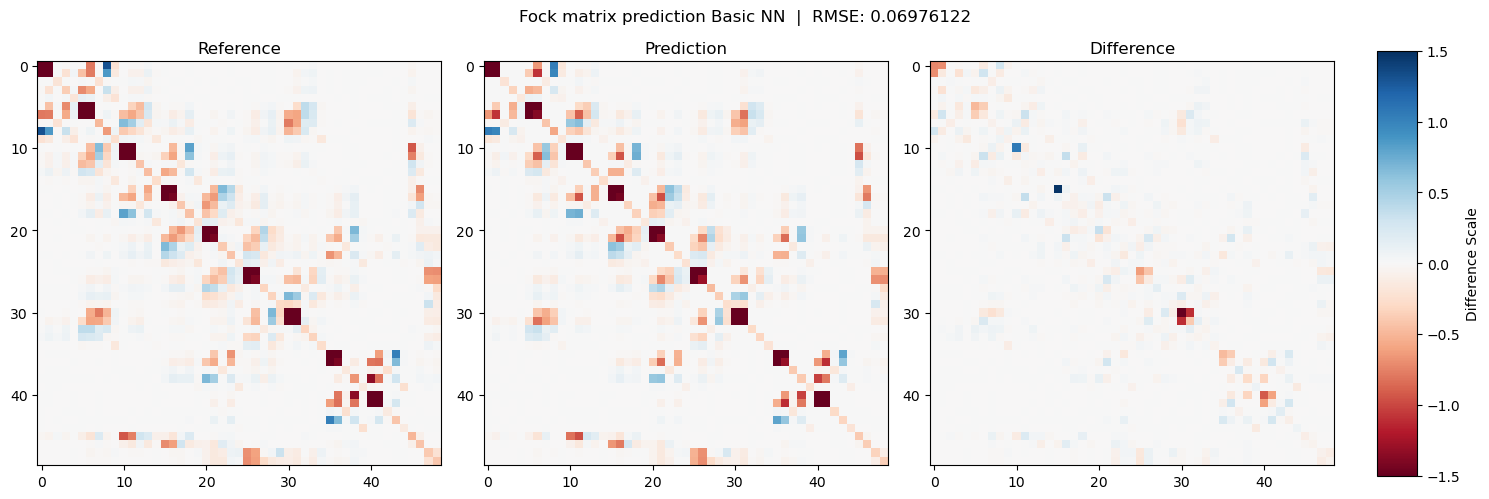

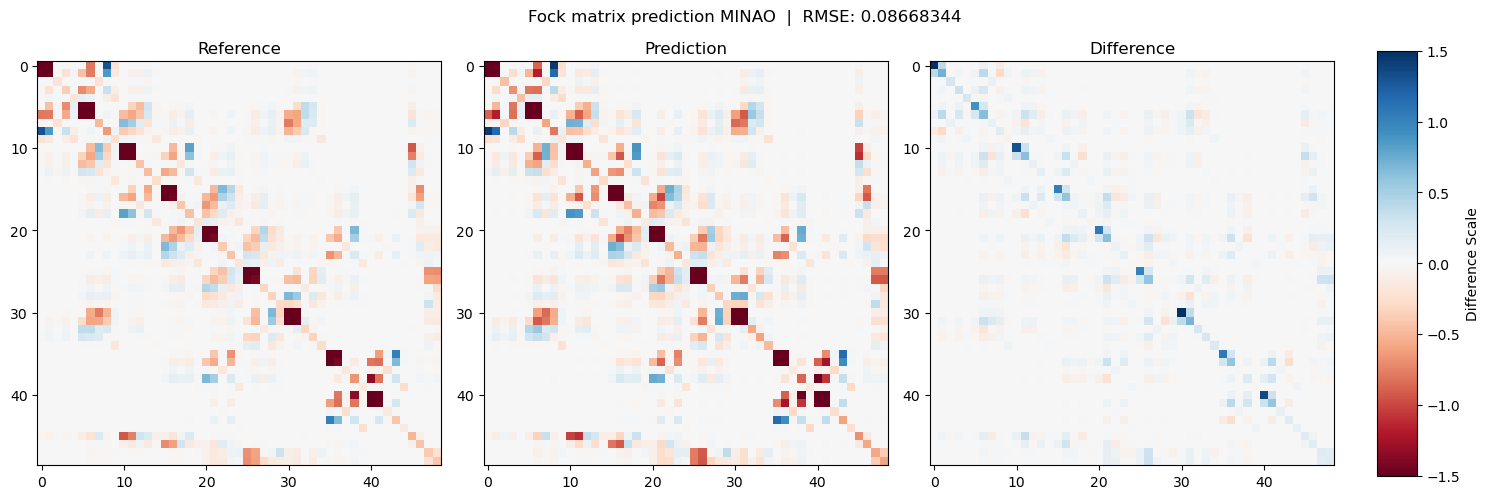

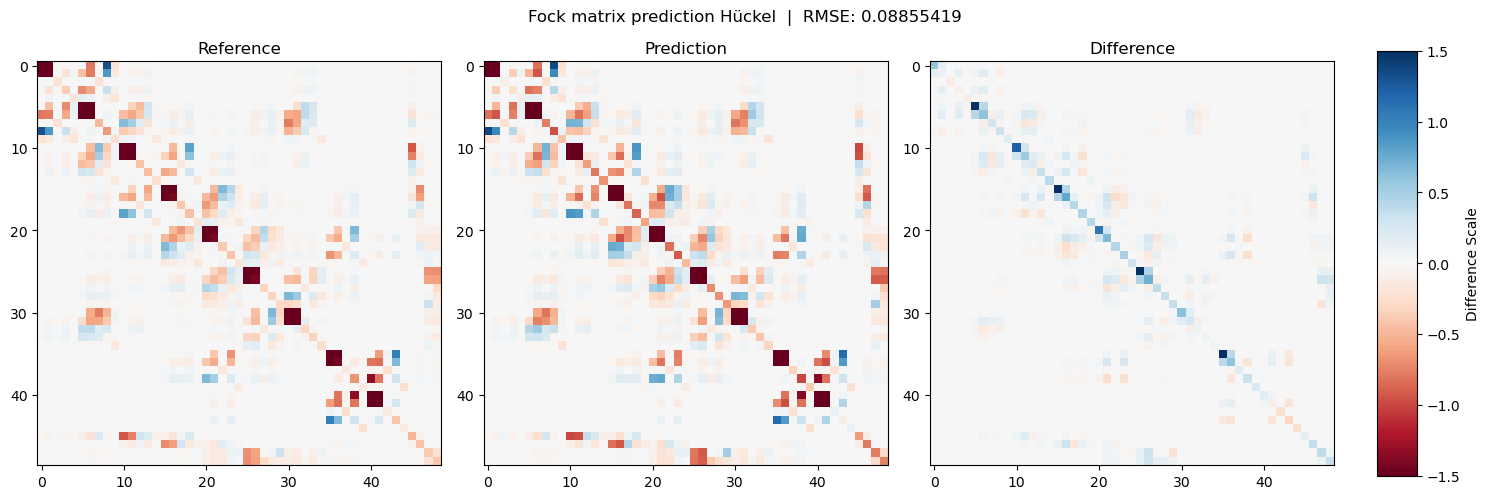

In [15]:
# example comparison: 
rand_test_sample = np.random.randint(0, len(test_pred_fock_diag))
pred_fock_example = reconstruct_Fock(test_pred_fock_diag[rand_test_sample], test_overlap_X[rand_test_sample])
ground_truth_fock_example = test_fock_full[rand_test_sample]
# compare with hückel and minao
test_mol = load(test_files[rand_test_sample], Backend.PY)
minao_guess = guess(test_mol, method="hf", basis="sto-3g", scheme="minao")
hueckel_guess = guess(test_mol, method="hf", basis="sto-3g", scheme="huckel")
plot_mat_comp(ground_truth_fock_example, pred_fock_example, title="Fock matrix prediction Basic NN")
plot_mat_comp(ground_truth_fock_example, minao_guess.fock().numpy, title="Fock matrix prediction MINAO")
plot_mat_comp(ground_truth_fock_example, hueckel_guess.fock().numpy, title="Fock matrix prediction Hückel")

Fock matrices look promising - let's check out the density matrices!

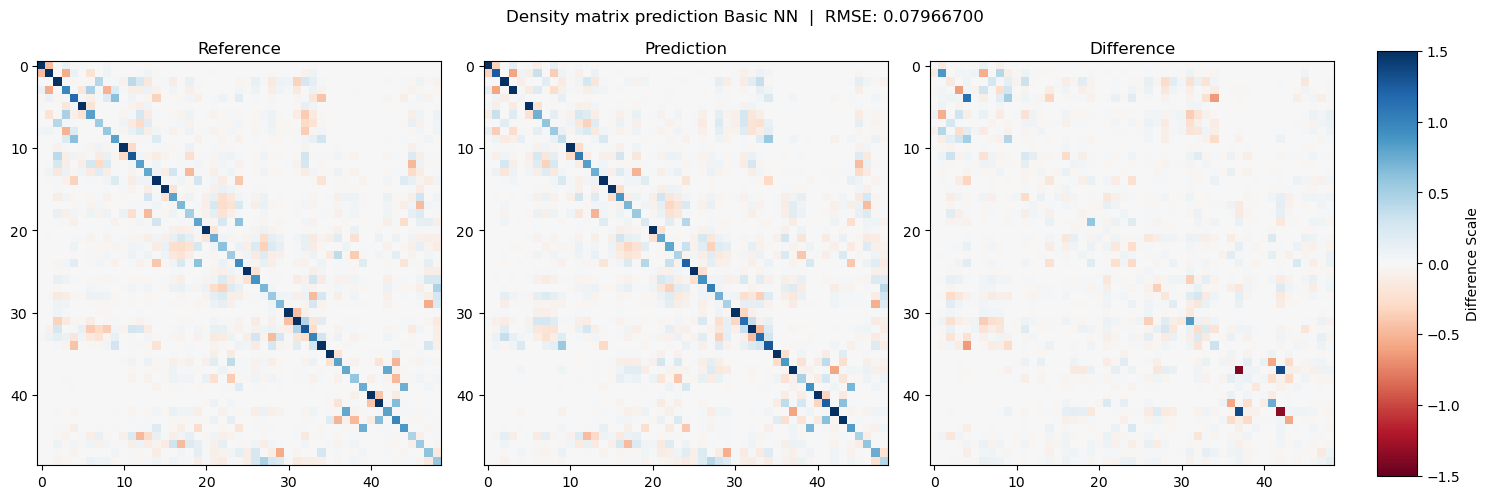

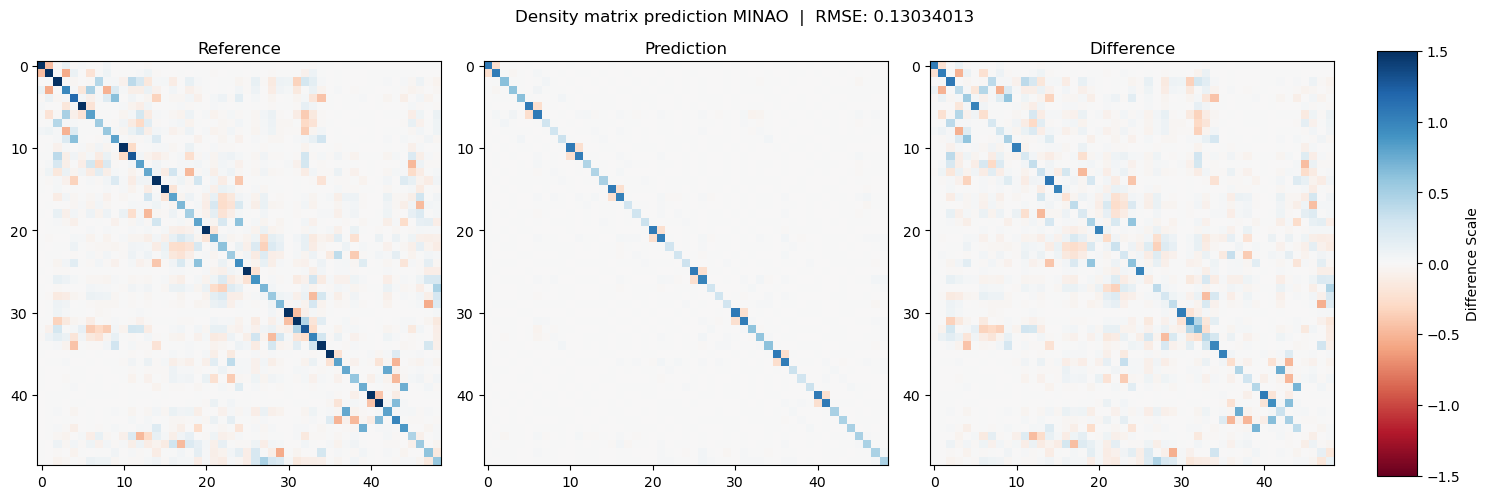

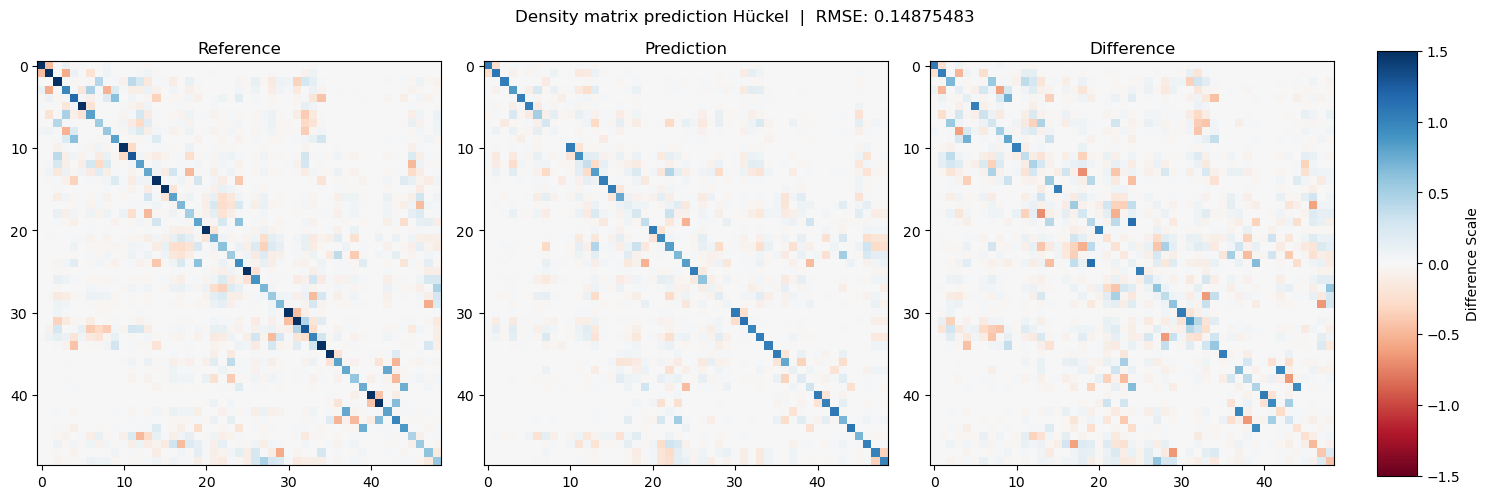

In [16]:
# Sanity check density reconstruction
ground_truth_density = 2*test_density_full[rand_test_sample]
#ground_truth_density_reconstucted = density_from_fock(test_fock_full[rand_test_sample], test_overlap_X[rand_test_sample], 32)
#plot_mat_comp(2*ground_truth_density, ground_truth_density_reconstucted, title="Sanity check density reconstruction (Ref: 2*ref density vs. density_from_fock(ref fock, ref overlap))")


pred_density_example = density_from_fock(pred_fock_example, test_overlap_X[rand_test_sample], 32)
plot_mat_comp(ground_truth_density, pred_density_example, title="Density matrix prediction Basic NN")
plot_mat_comp(ground_truth_density, minao_guess.density().numpy, title="Density matrix prediction MINAO")
plot_mat_comp(ground_truth_density, hueckel_guess.density().numpy, title="Density matrix prediction Hückel")

In [16]:
# sanity check guessing: 
rand_test_sample = 0
test_mol = load(test_files[rand_test_sample], Backend.PY)
wf = calculate(test_mol, basis="sto-3g", guess="minao", method="dft", functional="b3lypg")
print(wf.native.cycles)
# compare with perform_calculation: 
res = perform_calculation(test_files[rand_test_sample], density_guess=2*guess(mol, method="dft", basis="sto-3g", scheme="minao", functional="b3lypg").density().numpy, basis_set="sto-3g", method="dft", functional="b3lypg")
print(res)
# not exactly the same? idk why - let internal alg guess!

converged SCF energy = -446.946703900965
11
converged SCF energy = -446.946703900705
{'cycles': 17, 'conv': True, 'summary': {'nuc': np.float64(433.8378878463838), 'e1': np.float64(-1469.297475153848), 'coul': np.float64(648.1255855077079), 'exc': np.float64(-59.612702100948866)}, 'wf': <pyscf.dft.rks.RKS object at 0x7f88d84da310>, 'mol': <pyscf.gto.mole.Mole object at 0x7f8951978910>}


In [19]:
NN_density_pred = [density_from_fock(reconstruct_Fock(diag, ovlp), ovlp, 32) for diag, ovlp in zip(test_pred_fock_diag, test_overlap_X)]
test_mols = [load(file, Backend.PY) for file in test_files]
# Minao_guesses = [guess(mol, method="dft", basis="sto-3g", scheme="minao", functional="b3lypg").density().numpy for mol in test_mols]
# One_e_guesses = [guess(mol, method="dft", basis="sto-3g", scheme="1e", functional="b3lypg").density().numpy  for mol in test_mols]
# Atom_guesses = [guess(mol, method="dft", basis="sto-3g", scheme="atom", functional="b3lypg").density().numpy  for mol in test_mols]
# Huckel_guesses = [guess(mol, method="dft", basis="sto-3g", scheme="huckel", functional="b3lypg").density().numpy  for mol in test_mols]
# VSAP_guesses = [guess(mol, method="dft", basis="sto-3g", scheme="vsap", functional="b3lypg").density().numpy  for mol in test_mols]

In [20]:
from uncertainties import ufloat
import time

In [29]:
# inference speed of models: 
times_ = {}
for scheme in ["NN", "Minao", "1e", "Atom", "Huckel", "VSAP"]: 
    if scheme == "NN": 
        times_[scheme] = []
        for ovlp in test_overlap_X:
            start = time.time()
            diag = basic_model.predict(flatten_triang(ovlp).reshape(1, -1)).squeeze()
            density_from_fock(reconstruct_Fock(diag, ovlp), ovlp, 32)
            end = time.time()
            times_[scheme].append((end - start))
    else:
        times_[scheme] = []
        for mol in test_mols:
            start = time.time()
            guess(mol, method="dft", basis="sto-3g", scheme=scheme, functional="b3lypg").density().numpy
            end = time.time()
            times_[scheme].append((end - start))
for key, value in times_.items():
    times_[key] = ufloat(np.mean(value), np.std(value))
print("Inference times for different schemes: ")
for key, value in times_.items():
    print(f"{key}: {value:.2f} s")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [32]:
benchmark_val = times_["Minao"]
for key, value in times_.items():
    print(f"{key}: {value:.4f} s - {value/benchmark_val:.3f}x comp. MINAO")

NN: 0.0559+/-0.0064 s - 1.166+/-0.656x comp. MINAO
Minao: 0.0480+/-0.0264 s - 1.000+/-0x comp. MINAO
1e: 0.0059+/-0.0010 s - 0.123+/-0.071x comp. MINAO
Atom: 0.0469+/-0.0230 s - 0.977+/-0.720x comp. MINAO
Huckel: 0.0593+/-0.0243 s - 1.236+/-0.849x comp. MINAO
VSAP: 0.3115+/-0.0348 s - 6.495+/-3.649x comp. MINAO


In [35]:
res = benchmark_cycles(test_files, density_guesses=[NN_density_pred, None, None, None, None, None], scheme_names=["NN", "Minao", "1e", "Atom", "Huckel", "VSAP"], basis_set="sto-3g", method="dft", functional="b3lypg", max_samples=50)

Starting scheme: NN
converged SCF energy = -446.946703900969
Finished scheme NN for file ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_028121.xyz: 13 cycles, converged: True
converged SCF energy = -446.816879400941
Finished scheme NN for file ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_131581.xyz: 18 cycles, converged: True
converged SCF energy = -446.808814673932
Finished scheme NN for file ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_131100.xyz: 13 cycles, converged: True
converged SCF energy = -446.8326151786
Finished scheme NN for file ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_131749.xyz: 18 cycles, converged: True
converged SCF energy = -446.954407732571
Finished scheme NN for file ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_025279.xyz: 12 cycles, converged: True
converged SCF energy = -446.937717046288
Finished scheme NN for file ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_024377.xyz: 13 cycles, converged: True
converged SCF energy = -446.882950708037
Finished scheme NN for file ../../dataset

In [ ]:
# save results
import os
os.makedirs("benchmark/basic_model", exist_ok=True)
with open("benchmark/basic_model/benchmark_results.pkl", "wb") as f:
    pickle.dump(res, f)

In [ ]:
# load results
with open("benchmark/basic_model/benchmark_results.pkl", "rb") as f:
    res = pickle.load(f)

In [37]:
for key, val in res.items():
    cycles = np.array(val["cycles"])
    converged = val["converged"]
    cycles = cycles[converged]
    cycle_avg = ufloat(np.mean(cycles), np.std(cycles))
    print(f"{key}: {cycle_avg:.2f} cycles - converged: {len(cycles)}/{len(converged)} - {len(cycles)/len(converged):.2f}x converged")

NN: 14.88+/-3.89 cycles - converged: 48/50 - 0.96x converged
Minao: 11.68+/-0.99 cycles - converged: 50/50 - 1.00x converged
1e: 23.21+/-3.55 cycles - converged: 34/50 - 0.68x converged
Atom: 11.44+/-0.75 cycles - converged: 50/50 - 1.00x converged
Huckel: 21.94+/-5.46 cycles - converged: 36/50 - 0.72x converged
VSAP: 12.74+/-1.02 cycles - converged: 50/50 - 1.00x converged
